In [1]:
from glob import glob

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve

In [2]:
def get_roc(filename):

    df = pd.read_csv(filename)
    n_sig_verts = df["n_signal_vertices"][0]
    model = df["generating_func"][0]
    model = "homoscedastic" if model == 'generate_graphs_1' else "heteroscedastic"

    rocs = []
    for method in ["omni", "mdmr", "stats"]:
        fpr, tpr, _ = roc_curve(df["label"], df[method], pos_label=0, drop_intermediate=False)
        tmp = pd.DataFrame({"method": method, "fpr": fpr, "tpr": tpr})
        rocs.append(tmp)

    rocs = pd.concat(rocs)
    df.reset_index(level=0, inplace=True, drop=True)
    rocs["n_sig_verts"] = n_sig_verts
    rocs["model"] = model
    return rocs

In [3]:
files = glob("results/tmp/*.csv")
files = [f for f in files if "/0-" not in f]
frames = [get_roc(filename) for filename in files]
df = pd.concat(frames)
df.reset_index(level=0, inplace=True, drop=True)

df.head()

,method,fpr,tpr,n_sig_verts,model
0,omni,0.0,0.00,25,homoscedastic
1,omni,0.0,0.04,25,homoscedastic
2,omni,0.0,0.08,25,homoscedastic
3,omni,0.0,0.12,25,homoscedastic
4,omni,0.0,0.16,25,homoscedastic


In [4]:
unique_params = df.groupby(["n_sig_verts", "model"]).size().reset_index().drop(columns=[0])
unique_params

,n_sig_verts,model
0,5,heteroscedastic
1,5,homoscedastic
2,10,heteroscedastic
3,10,homoscedastic
4,15,heteroscedastic
5,15,homoscedastic
6,20,heteroscedastic
7,20,homoscedastic
8,25,heteroscedastic
9,25,homoscedastic


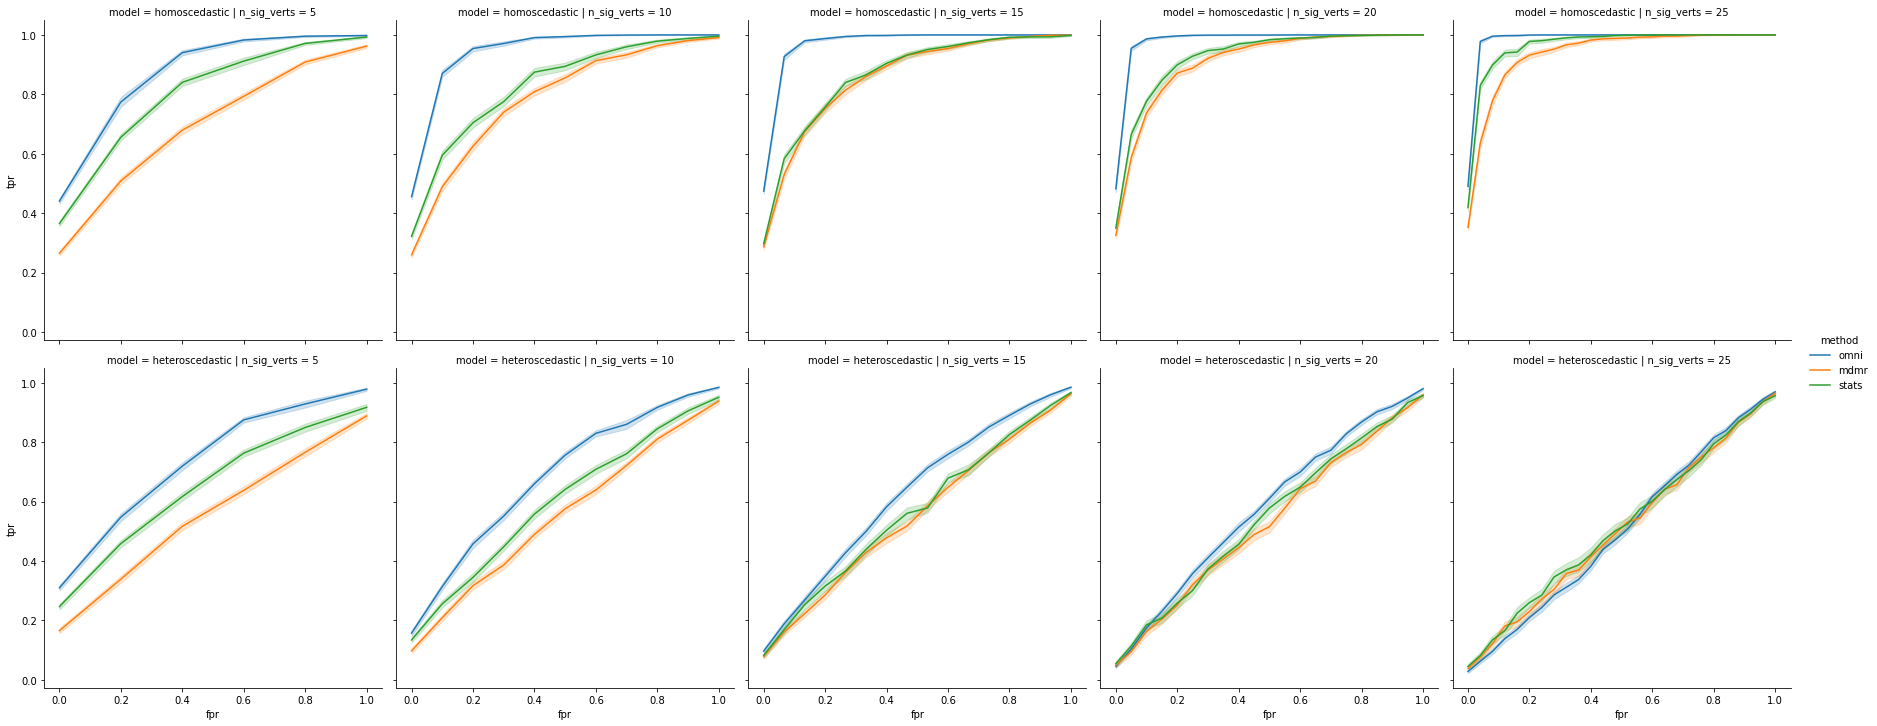

In [5]:
g = sns.relplot(
    x="fpr",
    y="tpr",
    hue="method",
    col="n_sig_verts",
    row="model",
    kind="line",
    data=df,
)
plt.show()